In [1]:
!pip install openpyxl
!pip install econml
!pip install shap
!pip install scikit-learn
!pip install pytorch_tabnet
!pip install datasets

In [2]:
import numpy as np
import pandas as pd
import scipy.stats
import sklearn
import xgboost
import shap

print("SHAP version:", shap.__version__)
print("XGBoost version:", xgboost.__version__)

SHAP version: 0.43.0
XGBoost version: 2.0.3


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch
from sklearn.metrics import accuracy_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
dfs=[]
for i in range(4):
  df=pd.read_excel('/content/drive/MyDrive/eLoriCorps-Database-E1-MAIN-IA-index-Y.xlsx',sheet_name=i)
  df=df.replace(999,np.nan)
  df=df.replace(888,np.nan)
  df=df.replace(999.0,np.nan)
  df=df.replace('20/04/1969',(2024-1969))
  df=df.replace('4/6/2000',(2024-2000))
  # df=df.replace(np.nan,None)
  dfs.append(df)


In [6]:
data1=dfs[0].interpolate()
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID-BDL             445 non-null    object 
 1   Poids              444 non-null    float64
 2   Taille             445 non-null    float64
 3   Age                444 non-null    float64
 4   EDI1               445 non-null    float64
 5   EDI2               445 non-null    float64
 6   EDI3               445 non-null    float64
 7   EDI4-INV           445 non-null    float64
 8   EDI5-INV           445 non-null    float64
 9   EDI6-INV           445 non-null    float64
 10  EDI7-INV           445 non-null    float64
 11  EDI8               445 non-null    float64
 12  EDI9               445 non-null    float64
 13  EDI10              445 non-null    float64
 14  EDI11              445 non-null    float64
 15  EDI12              445 non-null    float64
 16  EDI13              445 non

In [7]:
wrongfilled=[]
for i in range(445):
  if data1['EDI-TOT-Y'][i]!=0 and data1['EDI-TOT-Y'][i]!=1:
    wrongfilled.append(i)
    if data1['EDI-TOT-Y'][i] > 0.5:
      data1['EDI-TOT-Y'][i]=1
    else:
      data1['EDI-TOT-Y'][i]=0



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
data1['Poids'][0]=np.mean(data1['Poids'])
data1['Age'][0]=np.mean(data1['Age'])
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID-BDL             445 non-null    object 
 1   Poids              445 non-null    float64
 2   Taille             445 non-null    float64
 3   Age                445 non-null    float64
 4   EDI1               445 non-null    float64
 5   EDI2               445 non-null    float64
 6   EDI3               445 non-null    float64
 7   EDI4-INV           445 non-null    float64
 8   EDI5-INV           445 non-null    float64
 9   EDI6-INV           445 non-null    float64
 10  EDI7-INV           445 non-null    float64
 11  EDI8               445 non-null    float64
 12  EDI9               445 non-null    float64
 13  EDI10              445 non-null    float64
 14  EDI11              445 non-null    float64
 15  EDI12              445 non-null    float64
 16  EDI13              445 non


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Axes: >

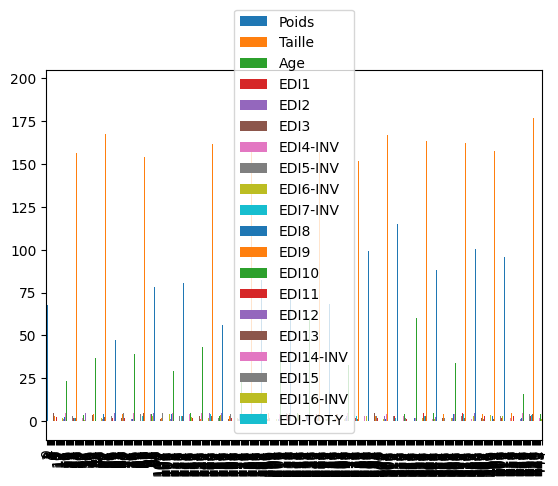

In [9]:
data1.drop(['ID-BDL','EDI-TOT','EDI-TOT-Index_F_M'], axis=1).plot(kind = 'bar')

In [10]:

# copy the data
data1scaled = data1.copy().drop(['ID-BDL','EDI-TOT','EDI-TOT-Index_F_M'], axis=1)

# apply normalization techniques
for column in data1scaled.columns:
    data1scaled[column] = data1scaled[column]  / data1scaled[column].abs().max()

# view normalized data
display(data1scaled)

,Poids,Taille,Age,EDI1,EDI2,EDI3,EDI4-INV,EDI5-INV,EDI6-INV,EDI7-INV,EDI8,EDI9,EDI10,EDI11,EDI12,EDI13,EDI14-INV,EDI15,EDI16-INV,EDI-TOT-Y
0,0.466935,0.830769,0.47388,0.800000,1.0,0.400000,1.000000,0.0,0.400000,0.800000,0.800000,0.40000,1.000000,0.8,0.0,1.000000,0.2,0.4,1.0,0.0
1,0.367568,0.846154,0.56250,0.800000,1.0,0.400000,1.000000,0.0,0.400000,0.800000,0.800000,0.40000,1.000000,0.8,0.0,1.000000,0.2,0.4,1.0,0.0
2,0.487027,0.830769,0.38750,0.400000,1.0,0.200000,1.000000,0.0,0.200000,0.600000,0.400000,0.60000,1.000000,0.4,0.2,1.000000,0.4,0.6,0.4,0.0
3,0.451757,0.856410,0.36250,0.409375,1.0,0.206349,0.993651,0.0,0.196875,0.590625,0.409375,0.60625,0.990476,0.4,0.2,0.993651,0.4,0.6,0.4,0.0
4,0.416486,0.882051,0.33750,0.418750,1.0,0.212698,0.987302,0.0,0.193750,0.581250,0.418750,0.61250,0.980952,0.4,0.2,0.987302,0.4,0.6,0.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,0.481081,0.846154,0.50000,0.600000,0.8,0.400000,0.600000,0.6,0.600000,0.800000,0.600000,0.60000,0.400000,0.8,0.6,0.600000,0.8,0.6,0.4,0.0
441,0.357297,0.789744,0.17500,0.000000,0.0,0.000000,0.200000,0.0,0.200000,1.000000,0.400000,0.80000,0.000000,0.0,0.0,0.000000,0.2,0.4,0.4,0.0
442,0.317838,0.820513,0.25000,0.100000,0.3,0.500000,0.100000,0.1,0.300000,0.700000,0.300000,0.70000,0.400000,0.2,0.0,0.200000,0.4,0.4,0.5,0.0
443,0.832432,0.856410,0.61250,0.200000,0.6,1.000000,0.000000,0.2,0.400000,0.400000,0.200000,0.60000,0.800000,0.4,0.0,0.400000,0.6,0.4,0.6,0.0


<Axes: >

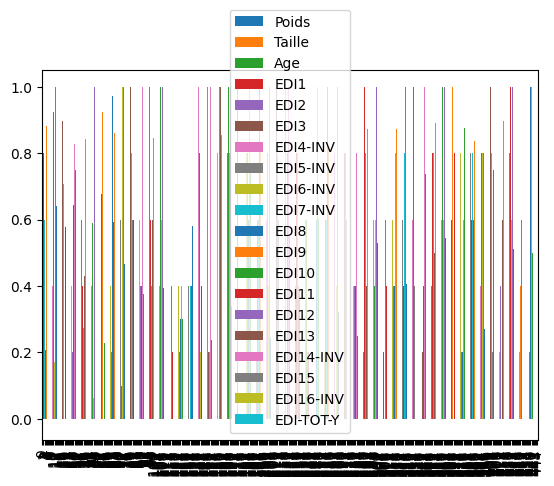

In [11]:
data1scaled.plot(kind = 'bar')

In [ ]:

# augmented_data = pd.concat([data1] , ignore_index=True)
# X = augmented_data.drop(['EDI-TOT-Y'], axis=1)
# y = augmented_data['EDI-TOT-Y']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Train = pd.concat([X_train, y_train], axis=1)
# Test = pd.concat([X_test, y_test], axis=1)
# __builtins__.X_train = X_train
# __builtins__.X_test = X_test
# __builtins__.Train = Train
# __builtins__.Test = Test

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data=data1scaled.copy()

target_column = 'EDI-TOT-Y'

# Separate features and target
X = data.drop(columns=[target_column])
y = data[target_column]

# Perform label encoding for categorical variables
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col])

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define TabNet classifier model
clf = TabNetClassifier(device_name='cuda' if torch.cuda.is_available() else 'cpu')

# Train the model
clf.fit(
    X_train=X_train.values,
    y_train=y_train.values,
    eval_set=[(X_train.values, y_train.values), (X_test.values, y_test.values)],
    eval_name=['train', 'test'],
    eval_metric=['accuracy'],
    max_epochs=300,  # Adjust as needed
    patience=300,  # Adjust as needed
    batch_size=256,  # Adjust as needed
    virtual_batch_size=32,  # Adjust as needed
    num_workers=0,  # Adjust as needed
    drop_last=False,
    loss_fn=None
)

# Evaluate the model
test_acc = accuracy_score(y_test, clf.predict(X_test.values))
print("Test accuracy:", test_acc)

import pandas as pd
from pytorch_tabnet.tab_model import TabNetClassifier



Device used : cuda


epoch 0  | loss: 1.17714 | train_accuracy: 0.85393 | test_accuracy: 0.8427  |  0:00:01s
epoch 1  | loss: 0.67266 | train_accuracy: 0.93539 | test_accuracy: 0.91011 |  0:00:01s
epoch 2  | loss: 0.47271 | train_accuracy: 0.93539 | test_accuracy: 0.91011 |  0:00:01s
epoch 3  | loss: 0.31756 | train_accuracy: 0.93539 | test_accuracy: 0.91011 |  0:00:01s
epoch 4  | loss: 0.2996  | train_accuracy: 0.93539 | test_accuracy: 0.91011 |  0:00:01s
epoch 5  | loss: 0.29239 | train_accuracy: 0.93539 | test_accuracy: 0.91011 |  0:00:01s
epoch 6  | loss: 0.24833 | train_accuracy: 0.93539 | test_accuracy: 0.91011 |  0:00:01s
epoch 7  | loss: 0.2494  | train_accuracy: 0.93539 | test_accuracy: 0.91011 |  0:00:01s
epoch 8  | loss: 0.17873 | train_accuracy: 0.9382  | test_accuracy: 0.91011 |  0:00:02s
epoch 9  | loss: 0.15645 | train_accuracy: 0.94101 | test_accuracy: 0.91011 |  0:00:02s
epoch 10 | loss: 0.16888 | train_accuracy: 0.94382 | test_accuracy: 0.91011 |  0:00:02s
epoch 11 | loss: 0.14379 | train

Best weights from best epoch are automatically used!


In [13]:
import numpy as np
import sklearn.model_selection
import xgboost

params = {
    'eta': 0.1,  # Increased learning rate
    'subsample': 0.9,  # Using more of the data for each tree
    'max_depth': 7,  # Allowing trees to grow deeper
    'objective': 'binary:logistic',  # Assuming a binary classification problem
    'eval_metric': 'logloss',  # Can be changed to 'auc', 'error', etc., based on the problem
}

def fit_xgboost(X, y):
    """Train an XGBoost model with early stopping and print the accuracy."""
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
    dtrain = xgboost.DMatrix(X_train, label=y_train)
    dtest = xgboost.DMatrix(X_test, label=y_test)
    model = xgboost.train(
    params,
    dtrain,
    num_boost_round=1000,  # Starting with a reasonable number of rounds
    evals=[(dtest, "test")],
    early_stopping_rounds=50,  # Adjust based on validation set performance
    verbose_eval=True,  # Set to True to see the training progress
    )
    # Predict the probabilities
    y_pred_prob = model.predict(dtest)
    # Convert probabilities to binary predictions
    y_pred = np.where(y_pred_prob > 0.5, 1, 0)

    # Calculate the accuracy
    accuracy = np.sum(y_pred == y_test) / len(y_test)
    print(f"Model accuracy: {accuracy:.4f}")

    return model


[0]	test-logloss:0.30618
[1]	test-logloss:0.29574
[2]	test-logloss:0.28642
[3]	test-logloss:0.27781
[4]	test-logloss:0.27006
[5]	test-logloss:0.26564
[6]	test-logloss:0.25815
[7]	test-logloss:0.25027
[8]	test-logloss:0.24442
[9]	test-logloss:0.24395
[10]	test-logloss:0.24008
[11]	test-logloss:0.23812
[12]	test-logloss:0.23443
[13]	test-logloss:0.23458
[14]	test-logloss:0.23300
[15]	test-logloss:0.23324
[16]	test-logloss:0.23215
[17]	test-logloss:0.23128
[18]	test-logloss:0.23135
[19]	test-logloss:0.22849
[20]	test-logloss:0.22910
[21]	test-logloss:0.22580
[22]	test-logloss:0.22422
[23]	test-logloss:0.22292
[24]	test-logloss:0.22330
[25]	test-logloss:0.22221
[26]	test-logloss:0.22362
[27]	test-logloss:0.22298
[28]	test-logloss:0.22476
[29]	test-logloss:0.22382
[30]	test-logloss:0.22446
[31]	test-logloss:0.22393
[32]	test-logloss:0.22332
[33]	test-logloss:0.22266
[34]	test-logloss:0.22493
[35]	test-logloss:0.22070
[36]	test-logloss:0.21790
[37]	test-logloss:0.21738
[38]	test-logloss:0.22

[21:15:02] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).


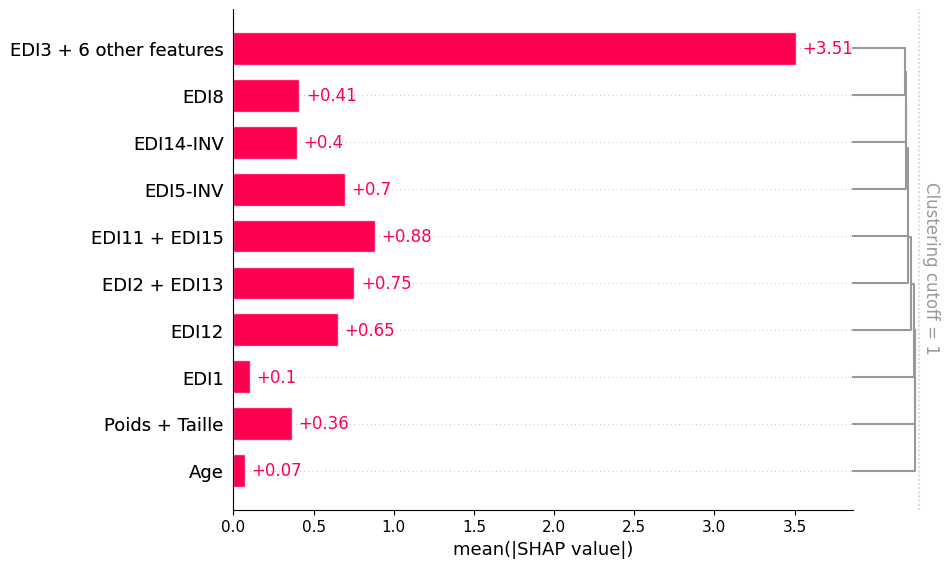

In [14]:
X = data.drop(columns=[target_column])
y = data[target_column]
model = fit_xgboost(X, y)
explainer = shap.Explainer(model)
shap_values = explainer(X)

clust = shap.utils.hclust(X, y, linkage="single")
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

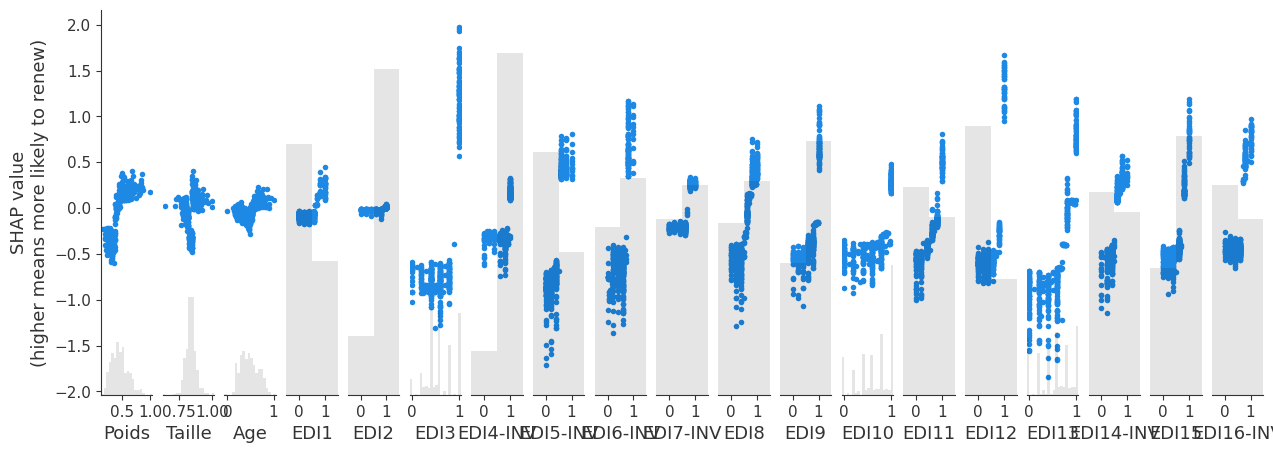

In [15]:
shap.plots.scatter(
    shap_values, ylabel="SHAP value\n(higher means more likely to renew)"
)

#need to fix below

In [ ]:
class FixableDataFrame(pd.DataFrame):
    """Helper class for manipulating generative models."""

    def __init__(self, *args, fixed={}, **kwargs):
        self.__dict__["__fixed_var_dictionary"] = fixed
        super().__init__(*args, **kwargs)

    def __setitem__(self, key, value):
        out = super().__setitem__(key, value)
        if isinstance(key, str) and key in self.__dict__["__fixed_var_dictionary"]:
            out = super().__setitem__(key, self.__dict__["__fixed_var_dictionary"][key])
        return out

In [ ]:
def intervention(data, fixed={}, seed=0):
  if seed is not None:
        np.random.seed(seed)
  X = FixableDataFrame(data.copy(), fixed=fixed)
  # Iterate over the fixed interventions and apply them
  for key, value in fixed.items():
      if key in X.columns:
          X[key] = value
  return X



In [ ]:
intervention(data_org,fixed={'Interactions':3}).iloc[6, :]

Sales calls      2.000000
Interactions     3.000000
Economy          0.236060
Last upgrade     5.100917
Discount         0.069827
Monthly usage    0.440016
Ad spend         0.430467
Bugs reported    1.000000
Y                1.000000
Name: 6, dtype: float64

In [ ]:

new_data = data_org[8000:]


X_new = new_data[feature_columns]

# Predict using the trained model
predictions = clf.predict(X_new.values)
print("Predictions:", predictions)

In [ ]:
def marginal_effects(data, columns=None, max_points=20, logit=True, seed=0):
    """Helper function to compute the true marginal causal effects."""
    X = intervention(data)
    if columns is None:
        columns = X.columns
    ys = [[] for _ in columns]
    xs = [X[c].values for c in columns]
    xs = np.sort(xs, axis=1)
    xs = [xs[i] for i in range(len(xs))]
    for i, c in enumerate(columns):
        xs[i] = np.unique(
            [
                np.nanpercentile(xs[i], v, method="nearest")
                for v in np.linspace(0, 100, max_points)
            ]
        )
        for x in xs[i]:
            Xnew = intervention(data, fixed={c: x}, seed=seed)
            Xnew = Xnew.drop(["Y"], axis=1)#droped column
            new_data =Xnew
            X_new = new_data[feature_columns]
            prediction = clf.predict(X_new.values)
            val = prediction.mean()
            if logit:
                val = scipy.special.logit(val)
            ys[i].append(val)
        ys[i] = np.array(ys[i])
    ys = [ys[i] - ys[i].mean() for i in range(len(ys))]
    return list(zip(xs, ys))


# shap.plots.scatter(
#     shap_values,
#     ylabel="SHAP value\n(higher means more likely to renew)",
#     overlay={"True causal effects": marginal_effects(generator, 10000, X.columns)},
# )

In [ ]:
def marginal_effects(data, columns=None, max_points=20, logit=True, seed=0):
    """Helper function to compute the true marginal causal effects."""
    X = intervention(data)
    if columns is None:
        columns = X.columns
    ys = [[] for _ in columns]
    xs = [X[c].values for c in columns]
    xs = np.sort(xs, axis=1)
    xs = [xs[i] for i in range(len(xs))]
    for i, c in enumerate(columns):
        xs[i] = np.unique(
            [
                np.nanpercentile(xs[i], v, method="nearest")
                for v in np.linspace(0, 100, max_points)
            ]
        )
        for x in xs[i]:
            Xnew = intervention(data, fixed={c: x}, seed=seed)
            Xnew = Xnew.drop(["Tested"], axis=1)
            new_data =Xnew
            X_new = new_data[feature_columns]
            prediction = clf.predict(X_new.values)
            val = prediction.mean()
            if logit:
                val = scipy.special.logit(val)
            ys[i].append(val)
        ys[i] = np.array(ys[i])
    ys = [ys[i] - ys[i].mean() for i in range(len(ys))]
    return list(zip(xs, ys))

In [ ]:
marginal_effects_data = marginal_effects(data_org[8000:])

In [ ]:
import numpy as np
from sklearn.neighbors import KernelDensity
from scipy.integrate import quad

# Function to fit KDE and return a probability density function
def fit_kde_and_get_pdf(column_data):
    # Reshape data for sklearn (it expects a 2D array)
    data = column_data.values.reshape(-1, 1)

    # Fit the KDE model
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data)

    # Define a function to represent the PDF using the KDE
    def pdf(x):
        return np.exp(kde.score_samples([[x]]))[0]

    return pdf

# Dictionary to hold the PDF functions for each column
pdf_functions = {}

for column in X:
    pdf_functions[column] = fit_kde_and_get_pdf(data[column])

# Now, pdf_functions contains a function for each column that computes the probability density.


In [ ]:
def PEACE(d):
  peace = {}
  for c in X.columns:
    index = X.columns.get_loc(c)
    effect = 0
    for i in range(1, len(marginal_effects_data[index][0])):
      effect += abs(marginal_effects_data[index][1][i] - marginal_effects_data[index][1][i-1])*(4*(pdf_functions[c](marginal_effects_data[index][0][i])*pdf_functions[c](marginal_effects_data[index][0][i-1]))**d)
    peace[c] = effect
  return peace

In [ ]:
import matplotlib.pyplot as plt

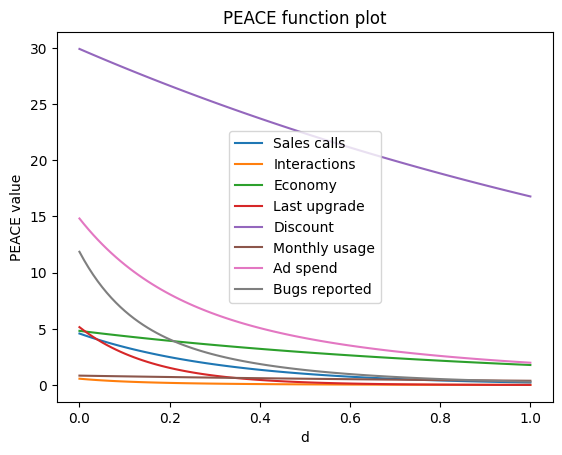

In [ ]:
d_values = np.linspace(0, 1, 100)
# Initialize a dictionary to hold the computed values
peace_values = {c: [] for c in X.columns}

# Compute PEACE(d) for each d value
for d in d_values:
    peace = PEACE(d)
    for c in peace:
        peace_values[c].append(peace[c])

# Plot the results
for c in peace_values:
    plt.plot(d_values, peace_values[c], label=c)

plt.xlabel('d')
plt.ylabel('PEACE value')
plt.title('PEACE function plot')
plt.legend()
plt.show()

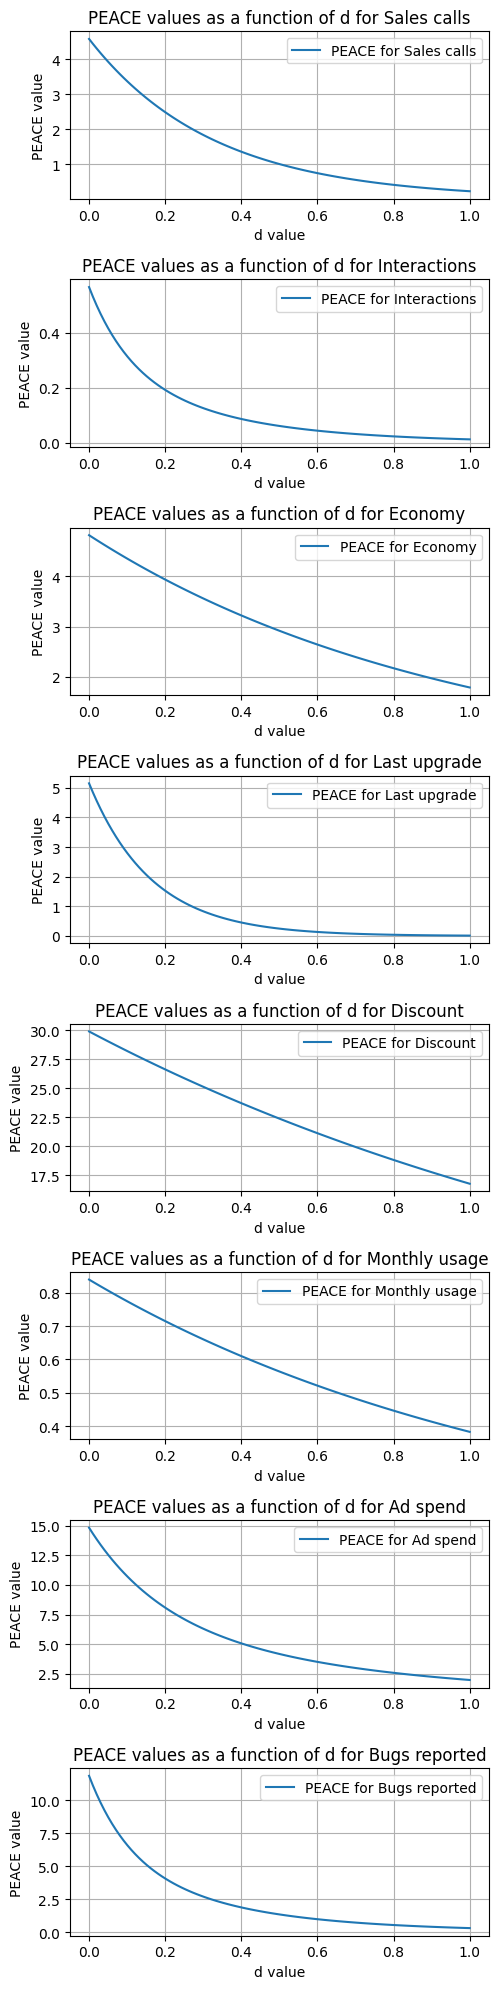

In [ ]:
num_columns = len(X.columns)
fig, axs = plt.subplots(num_columns, 1, figsize=(5, 3 * num_columns))

for i, (c, values) in enumerate(peace_values.items()):
    ax = axs[i] if num_columns > 1 else axs
    ax.plot(d_values, values, label=f'PEACE for {c}')
    ax.set_xlabel('d value')
    ax.set_ylabel('PEACE value')
    ax.set_title(f'PEACE values as a function of d for {c}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def positive(r):
  return max(r,0)

def PEACE_positive(d):
  peace_positive = {}
  for c in X.columns:
    index = X.columns.get_loc(c)
    effect = 0
    for i in range(1, len(marginal_effects_data[index][0])):
      effect += positive(marginal_effects_data[index][1][i] - marginal_effects_data[index][1][i-1])*((4*pdf_functions[c](marginal_effects_data[index][0][i])*pdf_functions[c](marginal_effects_data[index][0][i-1])**d))
    peace_positive[c] = effect
  return peace_positive

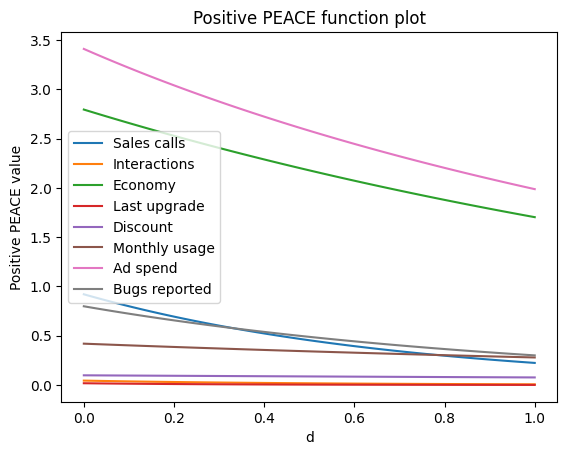

In [ ]:
# Initialize a dictionary to hold the computed values
peace_positive_values = {c: [] for c in X.columns}

# Compute PEACE(d) for each d value
for d in d_values:
    peace_positive = PEACE_positive(d)
    for c in peace:
        peace_positive_values[c].append(peace_positive[c])

# Plot the results
for c in peace_positive_values:
    plt.plot(d_values, peace_positive_values[c], label=c)

plt.xlabel('d')
plt.ylabel('Positive PEACE value')
plt.title('Positive PEACE function plot')
plt.legend()
plt.show()

In [ ]:
def negative(r):
  return max(-r,0)

def PEACE_negative(d):
  peace_negative = {}
  for c in X.columns:
    index = X.columns.get_loc(c)
    effect = 0
    for i in range(1, len(marginal_effects_data[index][0])):
      effect += negative(marginal_effects_data[index][1][i] - marginal_effects_data[index][1][i-1])*((4*pdf_functions[c](marginal_effects_data[index][0][i])*pdf_functions[c](marginal_effects_data[index][0][i-1])**d))
      peace_negative[c] = effect
  return peace_negative

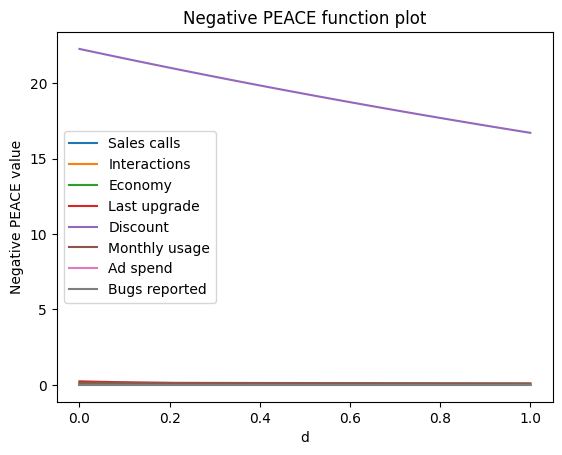

In [ ]:
# Initialize a dictionary to hold the computed values
peace_negative_values = {c: [] for c in X.columns}

# Compute PEACE(d) for each d value
for d in d_values:
    peace_negative = PEACE_negative(d)
    for c in peace:
        peace_negative_values[c].append(peace_negative[c])

# Plot the results
for c in peace_negative_values:
    plt.plot(d_values, peace_negative_values[c], label=c)

plt.xlabel('d')
plt.ylabel('Negative PEACE value')
plt.title('Negative PEACE function plot')
plt.legend()
plt.show()

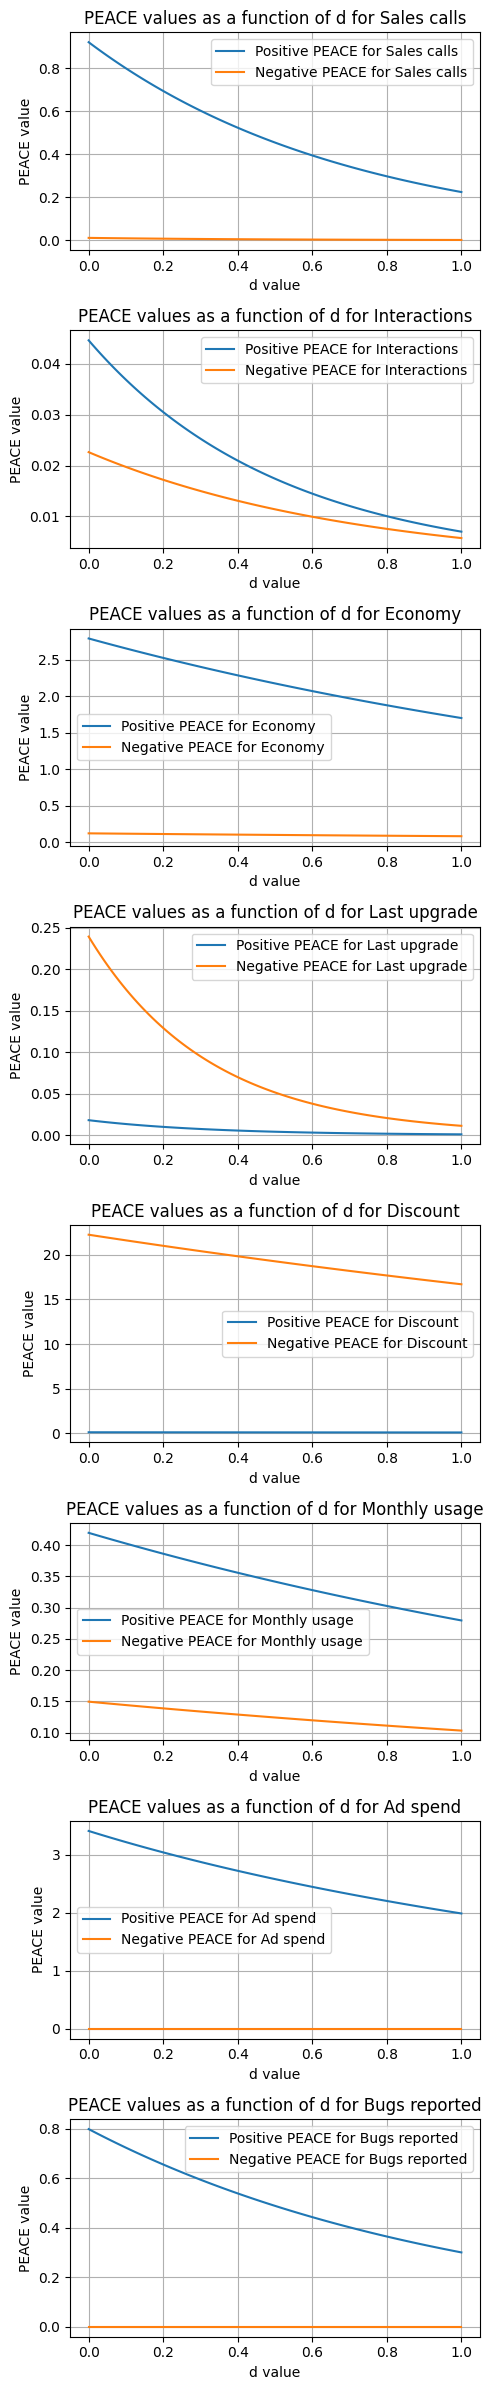

In [ ]:
fig, axs = plt.subplots(num_columns, 1, figsize=(5, 3 * num_columns))

for i, c in enumerate(peace_positive_values.keys()):
    ax = axs[i] if num_columns > 1 else axs
    ax.plot(d_values, peace_positive_values[c], label=f'Positive PEACE for {c}')
    ax.plot(d_values, peace_negative_values[c], label=f'Negative PEACE for {c}')
    ax.set_xlabel('d value')
    ax.set_ylabel('PEACE value')
    ax.set_title(f'PEACE values as a function of d for {c}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()